# Adding river levels
*Developed by R.A. Collenteur & D. Brakenhoff*

In this example it is shown how to create a Pastas model that not only includes precipitation and evaporation, but also observed river levels. We will consider observed heads that are strongly influenced  by river level, based on a visual interpretation of the raw data.

In [1]:
import pandas as pd
import pastas as ps
import matplotlib.pyplot as plt

%matplotlib notebook

ps.show_versions()
ps.set_log_level("ERROR")

Python version: 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 22:45:16) 
[Clang 9.0.1 ]
Numpy version: 1.17.5
Scipy version: 1.4.1
Pandas version: 1.0.3
Pastas version: 0.14.0b


## 1. import and plot data
Before a model is created, it is generally a good idea to try and visually interpret the raw data and think about possible relationship between the time series and hydrological variables. Below the different time series are plotted.

The top plot shows the observed heads, with different observation frequencies and some gaps in the data. Below that the observed river levels, precipitation and evaporation are shown. Especially the river level show a clear relationship with the observed heads. Note however how the range in the river levels is about twice the range in the heads. Based on these observations, we would expect the the final step response of the head to the river level to be around 0.5 [m/m]. 

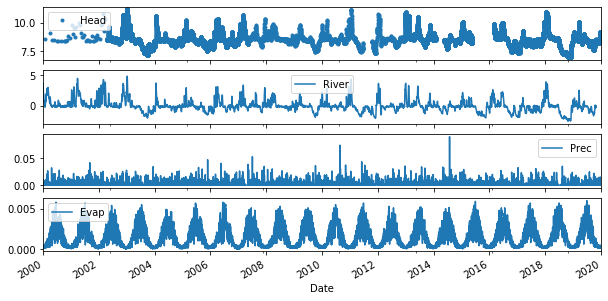

In [2]:
oseries = pd.read_csv("../data/nb5_head.csv", parse_dates=True, 
                      squeeze=True, index_col=0)
rain = pd.read_csv("../data/nb5_prec.csv", parse_dates=True, squeeze=True, 
                   index_col=0)
evap = pd.read_csv("../data/nb5_evap.csv", parse_dates=True, squeeze=True, 
                   index_col=0)
waterlevel = pd.read_csv("../data/nb5_riv.csv", parse_dates=True, 
                         squeeze=True, index_col=0)

fig, axes = plt.subplots(4,1, figsize=(10, 5), sharex=True)
oseries.plot(ax=axes[0], x_compat=True, legend=True, marker=".", linestyle=" ")
waterlevel.plot(ax=axes[1], x_compat=True, legend=True)
rain.plot(ax=axes[2], x_compat=True, legend=True)
evap.plot(ax=axes[3], x_compat=True, legend=True)
plt.xlim("2000", "2020");

## 2. Create a timeseries model
First we create a model with precipitation and evaporation as explanatory time series. The results show that precipitation and evaporation can explain part of the fluctuations in the observed heads, but not all of them.

Model Results River Model           Fit Statistics
nfev     21                     EVP          38.52
nobs     6050                   R2            0.38
noise    True                   RMSE          0.46
tmin     2000-01-27 00:00:00    AIC           2.71
tmax     2020-01-21 00:00:00    BIC          36.25
freq     D                      ___               
warmup   3650 days 00:00:00     ___               
solver   LeastSquares           ___               

Parameters (5 were optimized)
                optimal   stderr     initial  vary
recharge_A   545.641513  ±15.99%  183.785267  True
recharge_a   224.662550  ±15.71%   10.000000  True
recharge_f    -1.532329   ±8.45%   -1.000000  True
constant_d     8.480126   ±1.42%    8.530099  True
noise_alpha   64.922650   ±5.86%    1.000000  True

Parameter correlations |rho| > 0.5
recharge_A recharge_a  0.97
recharge_f constant_d -0.97


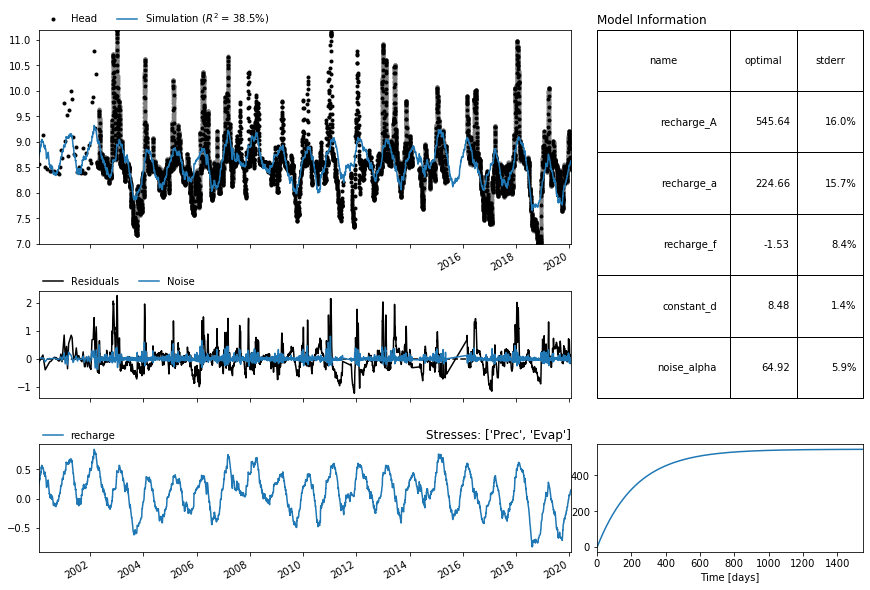

In [3]:
ml = ps.Model(oseries, name="River Model")

sm = ps.RechargeModel(rain, evap, rfunc=ps.Exponential, name="recharge")
ml.add_stressmodel(sm)

ml.solve(tmin="2000")
ml.plots.results(figsize=(12, 8));

## 3. Adding river water levels
Based on the analysis of the raw data, we expect that the river levels can help to explain the fluctuations in the observed heads. Here, we add a stress model (`ps.StressModel`) to add the rivers level as an explanatory time series to the model. The model fit is greatly improved, showing that the rivers help in explaining the observed fluctuations in the observed heads. It can also be observed how the response of the head to the river levels is a lot faster than the response to precipitation and evaporation.

Model Results River Model            Fit Statistics
nfev     23                     EVP           95.43
nobs     6050                   R2             0.95
noise    True                   RMSE           0.13
tmin     2000-01-27 00:00:00    AIC           11.39
tmax     2020-01-21 00:00:00    BIC           58.34
freq     D                      ___                
warmup   3650 days 00:00:00     ___                
solver   LeastSquares           ___                

Parameters (7 were optimized)
                 optimal   stderr     initial  vary
recharge_A    167.107980  ±12.59%  183.785267  True
recharge_a    191.849969  ±12.32%   10.000000  True
recharge_f     -1.392901   ±7.56%   -1.000000  True
waterlevel_A    0.476146   ±0.18%    1.000000  True
waterlevel_a    0.020297   ±0.00%   10.000000  True
constant_d      8.532987   ±0.38%    8.530099  True
noise_alpha    54.291165   ±5.52%    1.000000  True

Parameter correlations |rho| > 0.5
recharge_A   recharge_a   0.97
             const

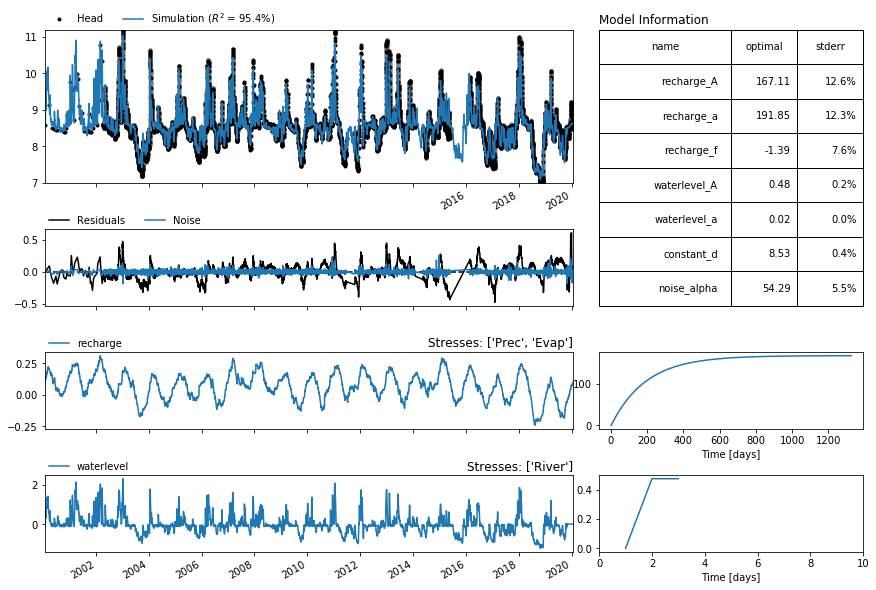

In [4]:
w = ps.StressModel(waterlevel, rfunc=ps.Exponential,  name="waterlevel", 
                   settings="waterlevel")
ml.add_stressmodel(w)
ml.solve(tmin="2000")
axes = ml.plots.results(figsize=(12, 8));
axes[-1].set_xlim(0,10);  # By default, the axes between responses are shared.